# Data-X: Project Pipeline
Takes models trained and explored from the rest of the project and outputs insights. Small interactive demo at the bottom of the notebook.
___

### Imports

In [83]:
# Import Python Packages
import re
import warnings

# Import Standard ML packages
import numpy as np
import pandas as pd

# Import and Configure Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16

%matplotlib inline

# Import Models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler

### Import Datasets

In [2]:
import_path = "../exported_models/airbnb_price_predictor.hdf"
predictor_X_df = pd.read_hdf(import_path, "X_df")
predictor_Y = pd.read_hdf(import_path, "Y")

In [3]:
import_path = "../exported_models/airbnb_price_trends.hdf"
trend_X_df = pd.read_hdf(import_path, "X_df")
trend_Y = pd.read_hdf(import_path, "Y")

In [4]:
import_path = "../exported_models/airbnb_rent_comparison.hdf"
jan17_df = pd.read_hdf(import_path, "jan17_df")
may18_df = pd.read_hdf(import_path, "may18_df")
aug18_df = pd.read_hdf(import_path, "aug18_df")
nov18_df = pd.read_hdf(import_path, "nov18_df")

### Price Predictor Setup

In [5]:
def scale_X(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

In [6]:
X = predictor_X_df.pipe(scale_X)
Y = predictor_Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

In [7]:
price_model = ensemble.GradientBoostingRegressor(loss="lad", n_estimators=300)
price_model.fit(X_train, y_train);

In [8]:
def cols_start_with(df, s):
    cols = df.columns
    cols = cols[cols.str.startswith(s)].values
    return list(cols)

def col_suffixes(df, s):
    cols = cols_start_with(df, s)
    cols = [re.sub(f"""{s}""", "", c) for c in cols]
    return cols

def val_one_hot_transform(df, val, col_prefix):
    cols = col_suffixes(df, col_prefix)
    result = pd.DataFrame()
    for c in cols:
        c_name = col_prefix + c
        if c == val:
            result[c_name] = [1]
        else:
            result[c_name] = [0]
    return result

In [9]:
def predict_price_input_to_X_df(
    longitude,
    latitude,
    accomodates,
    bedrooms,
    bathrooms,
    beds,
    room_type,
    neighbourhood_cleansed,
    zipcode
):
    X_df = pd.DataFrame()
    X_df["longitude"] = [longitude]
    X_df["latitude"] = [latitude]
    X_df["accomodates"] = [accomodates]
    X_df["bedrooms"] = [bedrooms]
    X_df["bathrooms"] = [bathrooms]
    X_df["beds"] = [beds]
    
    X_df = pd.concat((X_df, val_one_hot_transform(predictor_X_df, room_type, "room_type_")), axis=1)
    X_df = pd.concat((X_df, val_one_hot_transform(predictor_X_df, neighbourhood_cleansed, "neighbourhood_cleansed_")), axis=1)
    X_df = pd.concat((X_df, val_one_hot_transform(predictor_X_df, zipcode, "zipcode_")), axis=1)
    
    return X_df

def predict_price(
    longitude,
    latitude,
    accomodates,
    bedrooms,
    bathrooms,
    beds,
    room_type,
    neighbourhood_cleansed,
    zipcode
):
    X_df = predict_price_input_to_X_df(
        longitude,
        latitude,
        accomodates,
        bedrooms,
        bathrooms,
        beds,
        room_type,
        neighbourhood_cleansed,
        zipcode
    )
    X = X_df.pipe(scale_X)
    return price_model.predict(X)[0]

In [15]:
test_X = np.concatenate((predictor_X_df.iloc[0, :6].values,["Entire home/apt", "Western Addition", "94117.0"]))

predict_price(*test_X)

186.71800179690547

### Price Trend Setup

In [11]:
X = trend_X_df.pipe(scale_X)
Y = trend_Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

In [12]:
trend_model = linear_model.Lasso(alpha=1, fit_intercept=True)
trend_model.fit(X_train, y_train);

In [17]:
def predict_trend_input_to_X_df(
    price_past,
    longitude,
    latitude,
    accomodates,
    bedrooms,
    bathrooms,
    beds,
    room_type,
    neighbourhood_cleansed,
    zipcode
):
    X_df = pd.DataFrame()
    X_df["price_past"] = [price_past]
    X_df["longitude"] = [longitude]
    X_df["latitude"] = [latitude]
    X_df["accomodates"] = [accomodates]
    X_df["bedrooms"] = [bedrooms]
    X_df["bathrooms"] = [bathrooms]
    X_df["beds"] = [beds]
    
    X_df = pd.concat((X_df, val_one_hot_transform(trend_X_df, room_type, "room_type_")), axis=1)
    X_df = pd.concat((X_df, val_one_hot_transform(trend_X_df, neighbourhood_cleansed, "neighbourhood_cleansed_")), axis=1)
    X_df = pd.concat((X_df, val_one_hot_transform(trend_X_df, zipcode, "zipcode_")), axis=1)
    
    return X_df

def predict_trend(
    price_past,
    longitude,
    latitude,
    accomodates,
    bedrooms,
    bathrooms,
    beds,
    room_type,
    neighbourhood_cleansed,
    zipcode
):
    X_df = predict_trend_input_to_X_df(
        price_past,
        longitude,
        latitude,
        accomodates,
        bedrooms,
        bathrooms,
        beds,
        room_type,
        neighbourhood_cleansed,
        zipcode
    )
    X = X_df.pipe(scale_X)
    return trend_model.predict(X)[0]

In [23]:
test_X = np.concatenate((trend_X_df.iloc[0, :7].values,["Private room", "Seacliff", "94121.0"]))

predict_trend(*test_X)

0.03527405810977451

### Rent Comparison Setup

In [24]:
def nbr_in_rent(c):
    return nov18_df.index.isin([c]).any()

In [25]:
def visualize_rent_history(nbr, num_bed):
    if not nbr_in_rent(nbr):
        warnings.warn("Rent prices unavailable for this neighbourhood.")
        return None
    
    beds_map = {
        0: "Studio",
        1: "1 Bed",
        2: "2 Beds",
        3: "3 Beds"
    }
    bed_col = beds_map[num_bed]
    
    dates = [1, 12+5, 12+8, 12+11]
    rent_prices = [
        jan17_df.loc[nbr, bed_col], 
        may18_df.loc[nbr, bed_col],
        aug18_df.loc[nbr, bed_col],
        nov18_df.loc[nbr, bed_col]
    ]
    
    plt.title(f"""Historical Data for {bed_col} Apartment in {nbr}""")
    plt.xticks(dates, ["Jan '17", "May '18", "Aug '18", "Nov '18"])
    plt.plot(dates, rent_prices, 'o-')
    plt.savefig('../plots/Airbnb Rent Comparison Sample Historical Rent.png', bbox_inches='tight')
    plt.show()

In [26]:
def get_rent_price(nbr, num_bed):
    if not nbr_in_rent(nbr):
        warnings.warn("Rent prices unavailable for this neighbourhood.")
        return None
    
    beds_map = {
        0: "Studio",
        1: "1 Bed",
        2: "2 Beds",
        3: "3 Beds"
    }
    bed_col = beds_map[num_bed]
    return nov18_df.loc[nbr, bed_col]

def price_comparison_stats(nbr, num_beds, airbnb_price):
    if not nbr_in_rent(nbr):
        warnings.warn("Rent prices unavailable for this neighbourhood.")
        return None
    
    rent_price = get_rent_price(nbr, num_beds)
    breakeven = rent_price/airbnb_price
    
    return {
        "airbnb_price": airbnb_price,
        "nbr": nbr,
        "num_bed": num_beds,
        "rent_price": rent_price,
        "breakeven_days": breakeven,
        "breakeven_ratio": breakeven/30
    }

def visualize_stats(stats):
    if stats == None or len(stats) != 6:
        warnings.warn("Stats dont have right properties")
        return None
    
    plt.figure(figsize=(16,4))
    plt.suptitle("Airbnb vs. Rent Prices")
    
    plt.subplot(1, 2, 1)
    plt.title("Price Comparison")
    plt.ylabel("Daily Price ($)")
    plt.xticks(np.arange(2), ["Average Rent", "Airbnb"])
    prices = [stats["rent_price"]/30, stats["airbnb_price"]]
    plt.bar(np.arange(2), prices)
    
    plt.subplot(1, 2, 2)
    plt.title("Breakeven Point")
    days = np.arange(31)
    price_day = days * stats["airbnb_price"]
    plt.xlabel("Days Airbnb is Rented")
    plt.ylabel("Cumulative Price")
    plt.axvline(x=stats["breakeven_days"], color="r")
    plt.text(
        stats["breakeven_days"]-1.05,
        25*stats["airbnb_price"],
        f"""Breakeven = {np.round(stats["breakeven_days"], 1)} days""",
        rotation=90,
        fontsize=14
    )
    plt.plot(days, price_day)
    plt.savefig('../plots/Airbnb Rent Comparison Sample.png', bbox_inches='tight')
    plt.show()

### Interactive Demo

In [79]:
def demo():
    longitude = input("Input Longitude of Property: ")
    latitude = input("Input Latitude of Property: ")
    accomodates = input("Input # Unit Can Accommodate: ")
    bedrooms = input("Input # Bedrooms: ")
    bathrooms = input("Input # Bathrooms: ")
    beds = input("Input # Beds: ")
    
    room_type = input(f"""
Input 1, 2, or 3:
1) Entire home/apt
2) Private room
3) Shared room
    """)
    if room_type not in ["1","2","3"]:
        print("Invalid input")
        return
    room_map = {
        "1": "Entire home/apt",
        "2": "Private room",
        "3": "Shared room"
    }
    room_type = room_map[room_type]
    
    neighbourhood_cleansed = input("Input Neighborhood: ")
    if neighbourhood_cleansed not in col_suffixes(predictor_X_df, "neighbourhood_cleansed_"):
        print("Invalid input")
        return
    
    zipcode = input("Input zipcode: ") + ".0"
    if zipcode not in col_suffixes(predictor_X_df, "zipcode_"):
        print("Invalid input")
        return
    
    longitude = float(longitude)
    latitude = float(latitude)
    accomodates = float(accomodates)
    bedrooms = float(bedrooms)
    bathrooms = float(bathrooms)
    beds = float(beds)
    
    predicted_price = predict_price(
        longitude,
        latitude,
        accomodates,
        bedrooms,
        bathrooms,
        beds,
        room_type,
        neighbourhood_cleansed,
        zipcode,
    )
    
    predicted_trend = predict_trend(
        predicted_price,
        longitude,
        latitude,
        accomodates,
        bedrooms,
        bathrooms,
        beds,
        room_type,
        neighbourhood_cleansed,
        zipcode,
    )
    
    print(f"""
    =======RESULTS=======
    Predicted price on Airbnb: ${np.round(predicted_price, 2)}
    Predicted price percentage change on Airbnb in a year: {np.round(predicted_trend * 100, 2)}%
    =====================
    """)
    
    return predicted_price, predicted_trend

In [103]:
sample_input = np.concatenate((trend_X_df.iloc[500, :7].values,["Private room", "Noe Valley", "94131.0"]))
sample_input

array(['180.0', '-122.4349448117207', '37.74703281054805', '2.0', '1.0',
       '1.0', '1.0', 'Private room', 'Noe Valley', '94131.0'],
      dtype='<U32')

In [104]:
predicted_price, predicted_trend = demo()

Input Longitude of Property: -122.4349
Input Latitude of Property: 37.7470
Input # Unit Can Accommodate: 2
Input # Bedrooms: 1
Input # Bathrooms: 1
Input # Beds: 1

Input 1, 2, or 3:
1) Entire home/apt
2) Private room
3) Shared room
    2
Input Neighborhood: Noe Valley
Input zipcode: 94131

    =======RESULTS=======
    Predicted price on Airbnb: $186.72
    Predicted price percentage change on Airbnb in a year: 3.53%
    


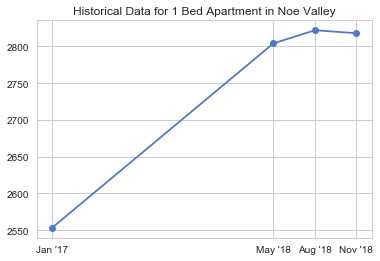

In [99]:
nbr = "Noe Valley"
num_beds = 1

visualize_rent_history(nbr, num_beds)

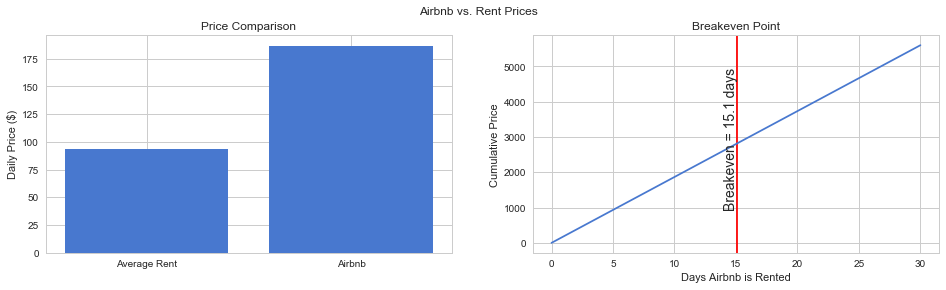

In [105]:
visualize_stats(price_comparison_stats(nbr, num_beds, predicted_price))